# **Initialization**

In [23]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import cm, pyplot as plot

import warnings, numpy, pandas
from pathlib import Path
from umap import UMAP   
from PIL import Image

warnings.filterwarnings('ignore')

SIZE = (512, 512)
PATH = Path('image_files/v0')  
LABELS = ['realistic', 'features', 'blurred', 'geons', 'silhouettes']
CLUSTER_NAMES = ['Airplane', 'Car', 'Chair', 'Cup', 'Dog', 'Donkey', 'Duck', 'Hat']

In [24]:
data = {}
for label in LABELS:
    components = []
    for file in sorted((PATH/label).iterdir()):
        image = Image.open(file).convert('L').resize(SIZE, Image.Resampling.LANCZOS)
        components.append(numpy.array(image, dtype=numpy.float32).flatten())
    components = numpy.array(components)
    scaler = StandardScaler()
    data[label] = {'components': scaler.fit_transform(components), 'scaler': scaler}

- `.convert('L')` converts the image to grayscale; The 'L' stands for Luminance channel or 8-bit grayscale. 'L' mode images have one channel per pixel (unlike 'RGB' which has three: red, green, blue).
- **Keeping the scaler:** To visually reconstruct images that can be compared with the originals, we must reverse this standardization using the same scaler.
> **Resampling**
>
> Resampling is the process of changing the dimensions of an image by adding or removing pixels when resizing it to a standardized size. LANCZOS method is a high-quality interpolation algorithm that calculates new pixel values when the image size changes.​ LANCZOS resampling uses a mathematical technique that looks at multiple surrounding pixels and computes a weighted average to determine each new pixel's value. This preserves image quality better than simpler methods like nearest neighbor, which just copies the closest pixel value.​

In [25]:
results = {}
for label in LABELS:    
    components = data[label]['components']    
    pca_model = PCA(n_components=min(components.shape))
    principal_components = pca_model.fit_transform(components)
    cumulative_variance = numpy.cumsum(pca_model.explained_variance_ratio_)
    results[label] = {
        'pca_model': pca_model,
        'principal_components': principal_components,
        'scaler': data[label]['scaler'],
        'explained_variance': pca_model.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance
    }
    minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)
    preserved_variance = cumulative_variance[minimum_components - 1]
    print(f'Label: {label}\nMinimum Number of Components: {minimum_components}\nPreserved Variance: {preserved_variance:.4f}')
    if label != LABELS[-1]:
            print()

Label: realistic
Minimum Number of Components: 30
Preserved Variance: 0.9524

Label: features
Minimum Number of Components: 33
Preserved Variance: 0.9562

Label: blurred
Minimum Number of Components: 23
Preserved Variance: 0.9525

Label: geons
Minimum Number of Components: 39
Preserved Variance: 0.9507

Label: silhouettes
Minimum Number of Components: 31
Preserved Variance: 0.9549


- `X.shape = (sample_count, feature_count)`; If we only have `n` data points (samples). We cannot find more than `n` independent patterns from them. `PCA(n_components=min(X.shape))` is a safety measure that works for both cases.
- Standardizing the pixel values for each label by centering them around zero and scaling them to unit variance is essential for PCA to work properly. If we standardized all the data together, differences between labels could be lost, and PCA might mix up the underlying patterns you want to analyze in each group.
- `argmax` finds the first index where the specified condition is `True`, but if there are none, it returns 0 by default, making `n_comp_95 = 1`, which is misleading.
- PCA is applied to find the principal components — new axes that capture the most variation in the data. The `n_components=min(X.shape)` ensures PCA computes as many components as possible given the data dimensions.
- The `explained_variance_ratio_` shows what percentage of total variance each principal component captures. The `cumulative_variance` sums these ratios to show how much total variance is explained by the first `n` components.
- `n_comp_95 = numpy.argmax(cumsum >= 0.95) + 1` finds the minimum number of components needed to explain at least 95% of the variance in the data. For example, if the original data has 262,144 dimensions (512×512 pixels), we might only need 50 components to capture 95% of the information — a massive dimensionality reduction.

# **Original vs PCA-Reconstructed Realistic Images (95% Variance Retained)**

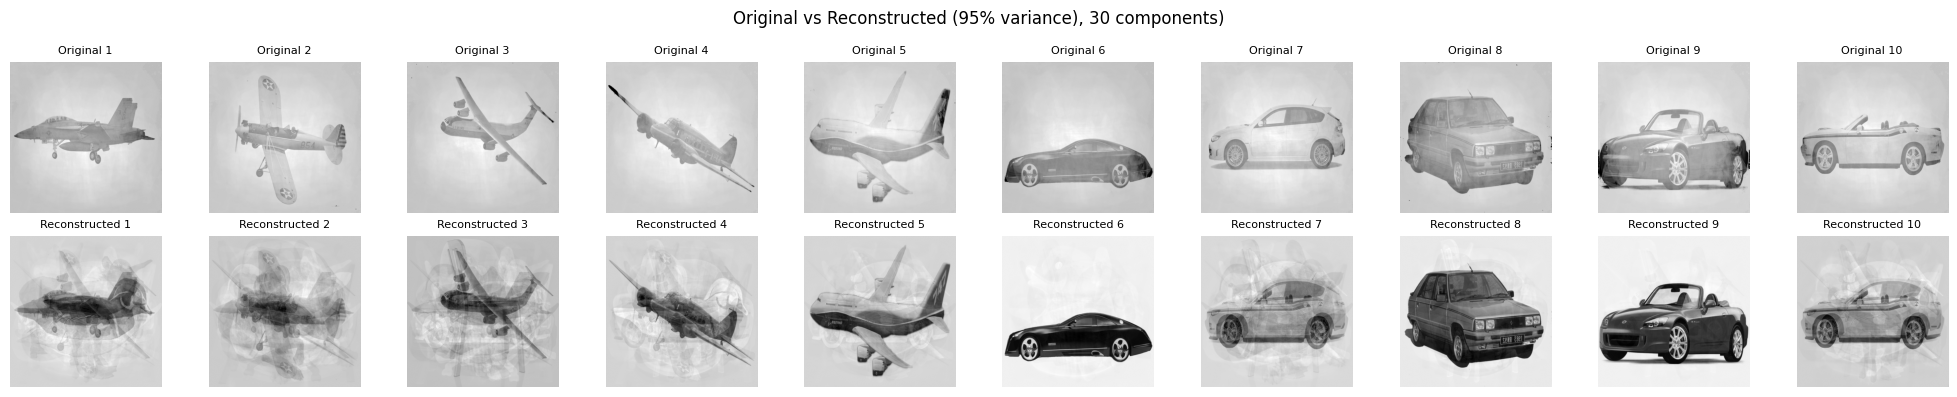

In [26]:
components = data['realistic']['components']
pca_model = results['realistic']['pca_model']
cumulative_variance = results['realistic']['cumulative_variance']

minimum_components = numpy.argmax(cumulative_variance >= 0.95) + 1 if numpy.any(cumulative_variance >= 0.95) else len(cumulative_variance)
principal_components = results['realistic']['principal_components'][:, :minimum_components]
principal_components_padded = numpy.column_stack([principal_components, numpy.zeros((principal_components.shape[0], pca_model.n_components_ - minimum_components))])
principal_components_reconstructed = results['realistic']['scaler'].inverse_transform(pca_model.inverse_transform(principal_components_padded))

figures, axes = plot.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    original = components[i].reshape(SIZE)
    reconstructed = principal_components_reconstructed[i].reshape(SIZE)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}', fontsize=8)
    axes[1, i].imshow(reconstructed, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Reconstructed {i+1}', fontsize=8)

plot.suptitle(f'Original vs Reconstructed (95% variance), {minimum_components} components)', fontsize=12)
plot.tight_layout()
plot.show()

# **2D Scatter Plots by Image Cluster**

Visualizing images in 2D space using the first two principal components. Each point represents an image, colored by its cluster (Airplane, Car, Chair, Cup, Dog, Donkey, Duck, Hat).

## **Principal Component Analysis**

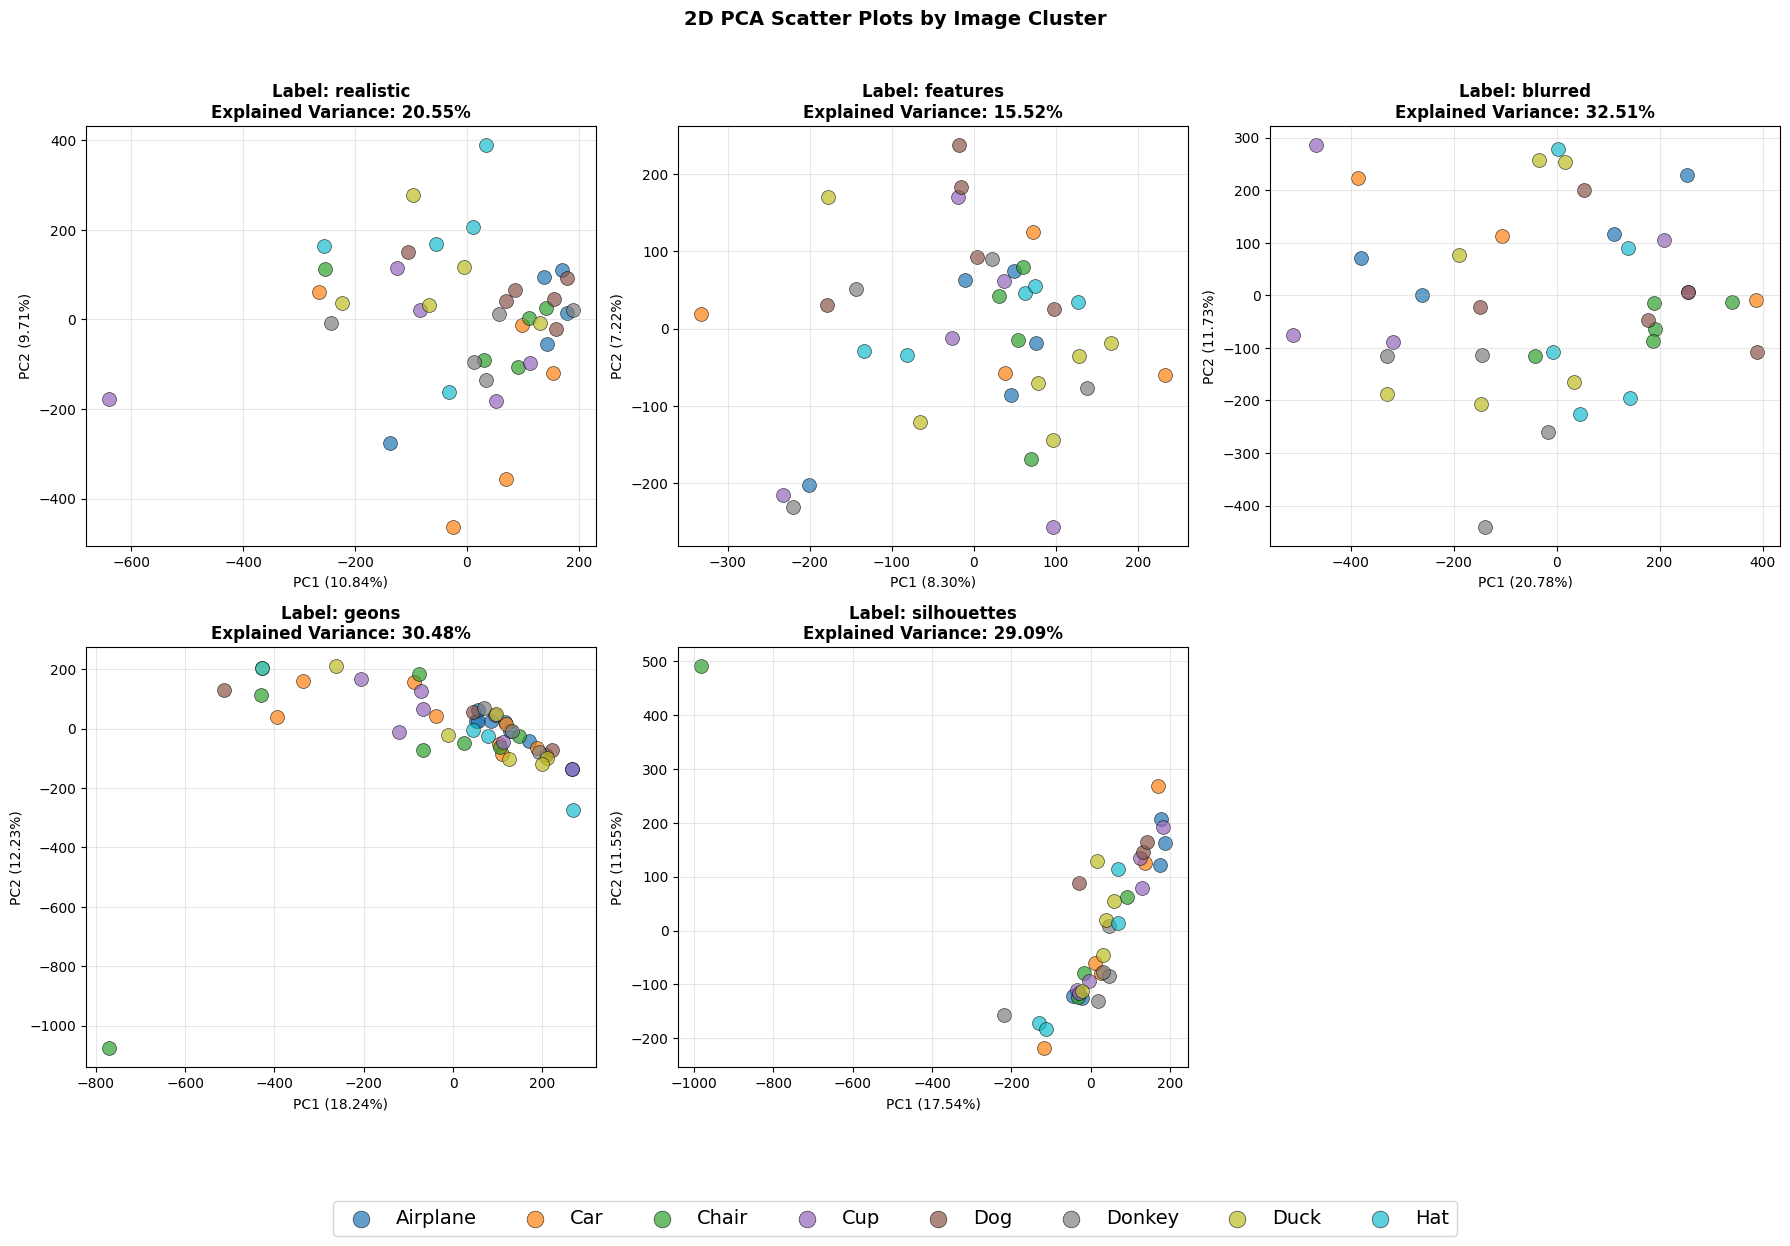

In [27]:
cmap = cm.get_cmap('tab10', len(CLUSTER_NAMES))
cluster_colors = {cluster_name: cmap(index) for index, cluster_name in enumerate(CLUSTER_NAMES)}

figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    pca_model = PCA(n_components=2)
    principal_components = pca_model.fit_transform(data[label]['components'])
    cumulative_variance = numpy.sum(pca_model.explained_variance_ratio_)
    
    clusters = []    
    paths = (PATH / label).iterdir()

    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        scatter = axis.scatter(
            principal_components[cluster_indices, 0], 
            principal_components[cluster_indices, 1], 
            color=cluster_colors[cluster], 
            label=cluster, 
            alpha=0.7, 
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
            
        if index == 0: 
            legend_handles.append(scatter)
            legend_labels.append(cluster)
    
    axis.set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%})', fontsize=10)
    axis.set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%})', fontsize=10)
    axis.set_title(f'Label: {label}\nExplained Variance: {cumulative_variance:.2%}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
    loc='lower center', 
    ncol=len(CLUSTER_NAMES), 
    fontsize=14,
    markerscale=1.2,
    frameon=True,
    bbox_to_anchor=(0.5, -0.05)
) 

plot.suptitle('2D PCA Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

### **Interpretation**

The main goal of this visualization is to see if the pre-defined **`CLUSTER_NAMES`** are meaningful and well-separated in the feature space:

1.  **Cluster Separation:**
    * **Good Separation:** If dots of the same color are tightly grouped together, and these groups are far apart from groups of different colors, it indicates that your feature representation is effective at **distinguishing between the clusters**.
    * **Poor Separation:** If dots of different colors are heavily mixed or overlap, it suggests that the features captured by the PCA model do not clearly differentiate between those specific clusters.

2.  **Cluster Compactness:**
    * A **tight, dense grouping** of points of the same color indicates that the features within that cluster are very similar to each other.
    * A **sparse, spread-out grouping** suggests that the features within that cluster have high internal variance (the cluster is diverse).

3.  **Variance Explained:**
    * The subplot title shows the **Total Explained Variance** (the sum of variance explained by PC1 and PC2). A higher percentage (e.g., 85%) means the 2D plot is a very accurate representation of the original high-dimensional data structure.
    * The axis labels show the individual variance explained by PC1 and PC2. Typically, PC1 explains significantly more variance than PC2.

## **t-Distributed Stochastic Neighbor Embedding**

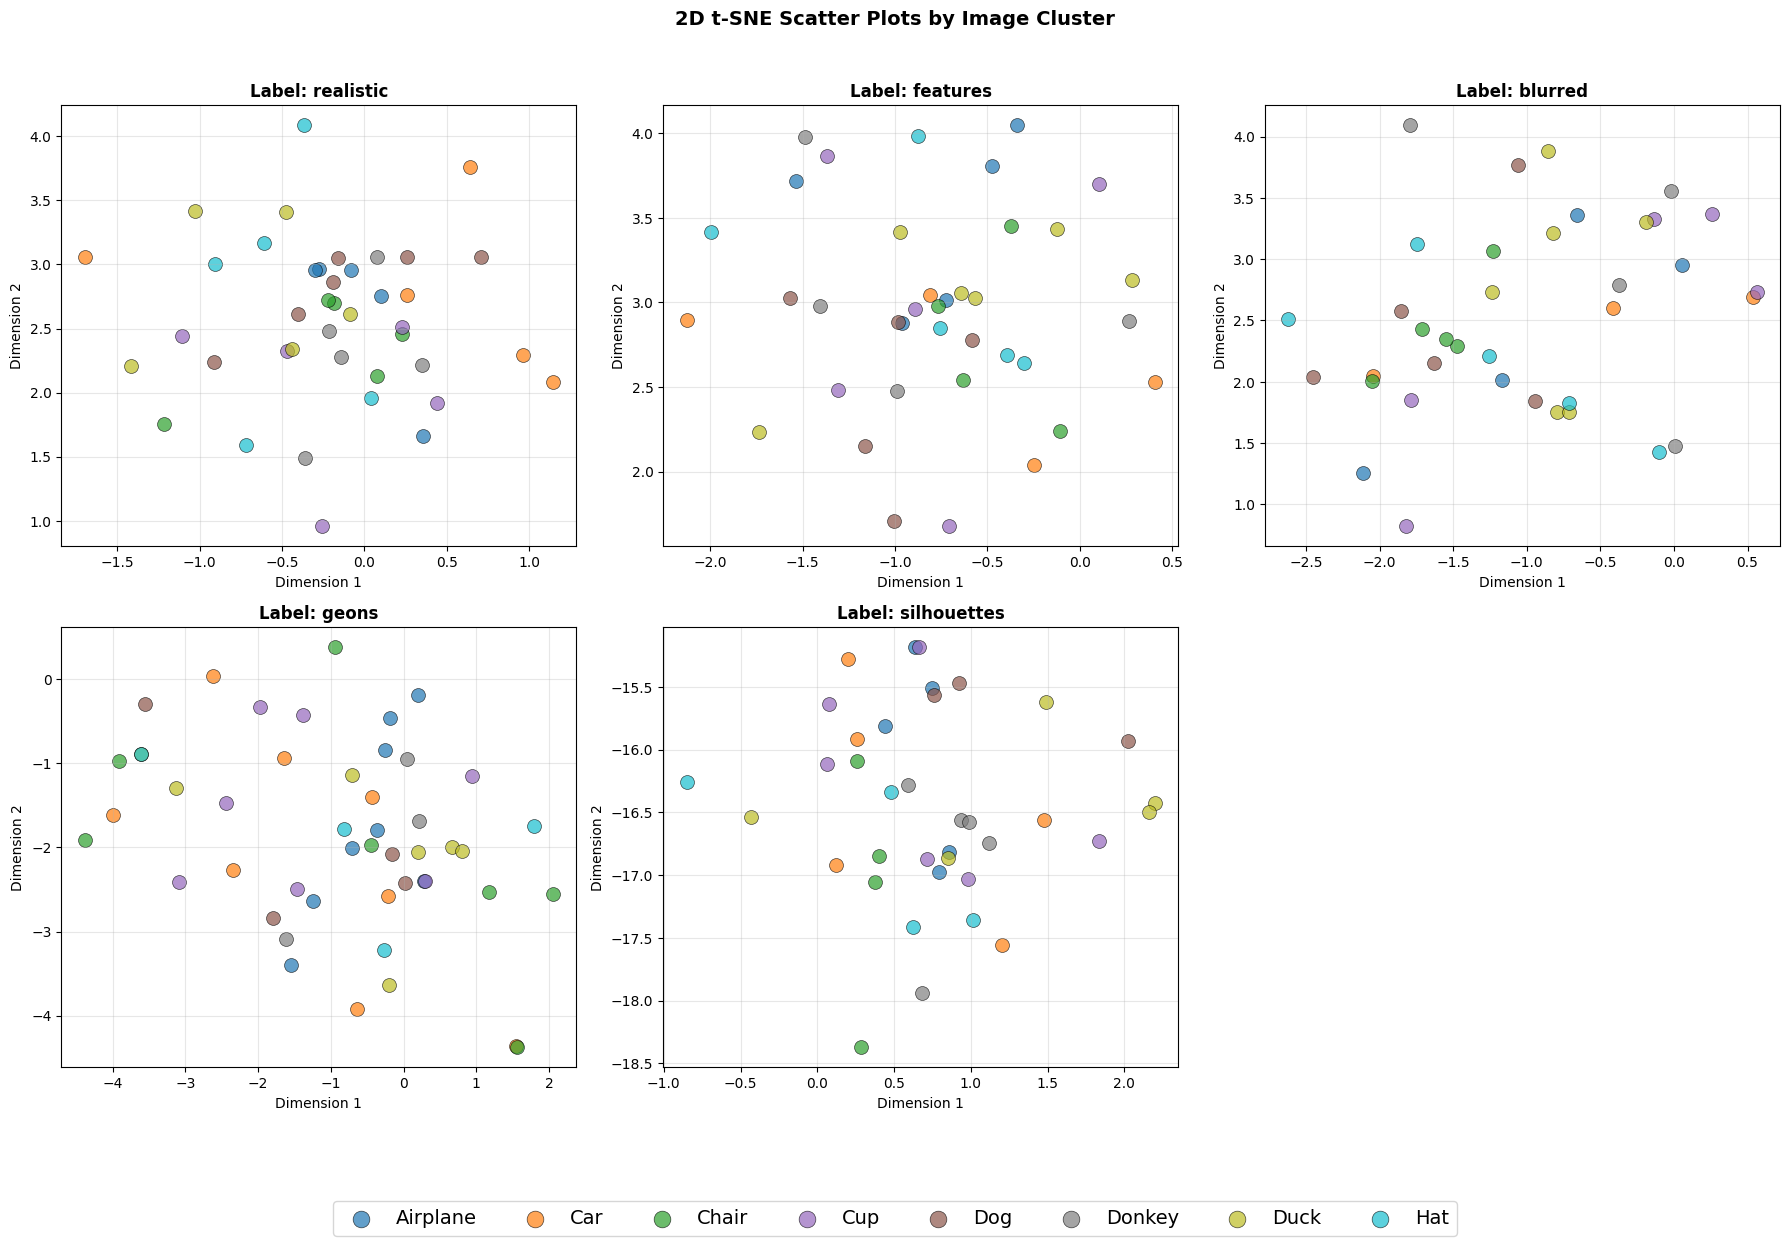

In [28]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
    principal_components = tsne_model.fit_transform(data[label]['components'])
    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
    
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D t-SNE Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

## **Locally Linear Embedding**

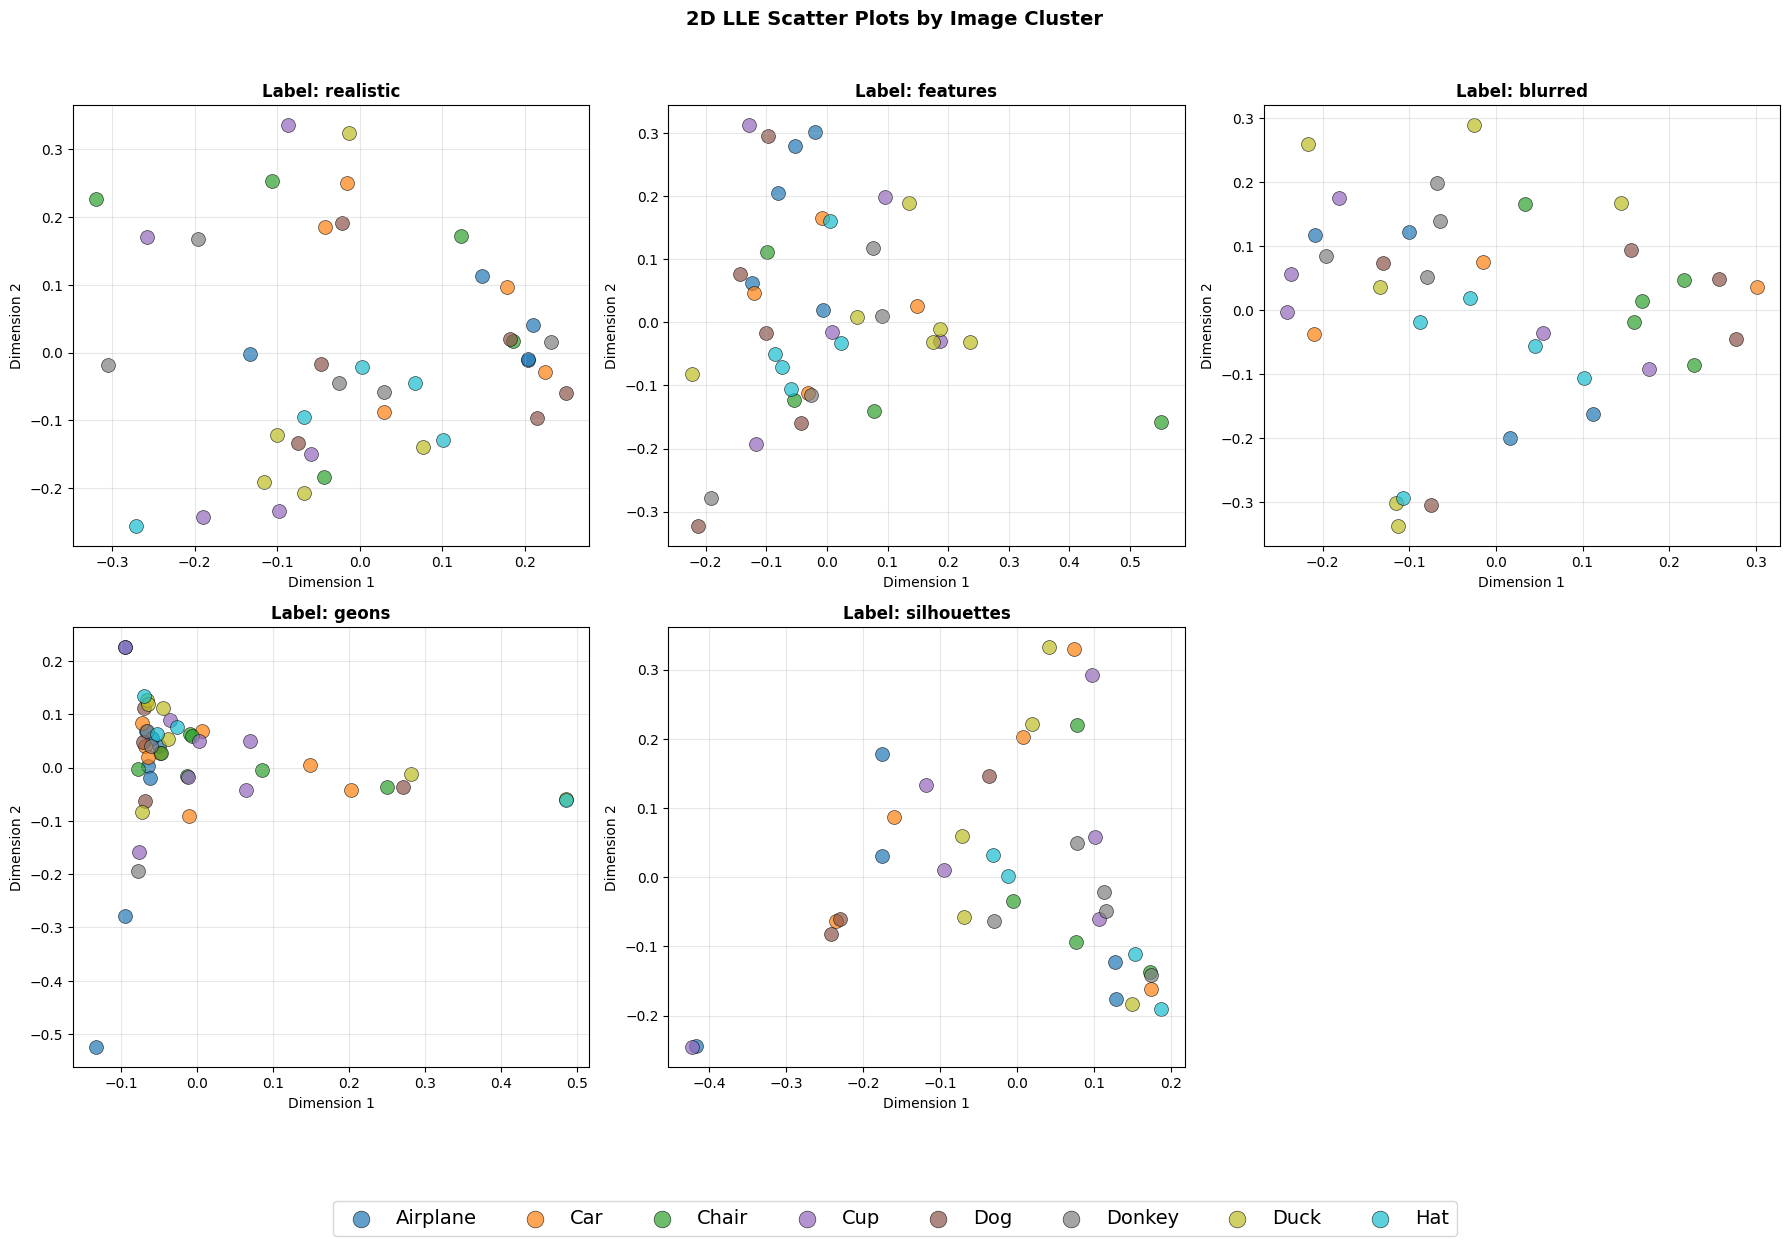

In [29]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    lle_model = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
    principal_components = lle_model.fit_transform(data[label]['components'])
    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
    
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D LLE Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()

## **Uniform Manifold Approximation and Projection**

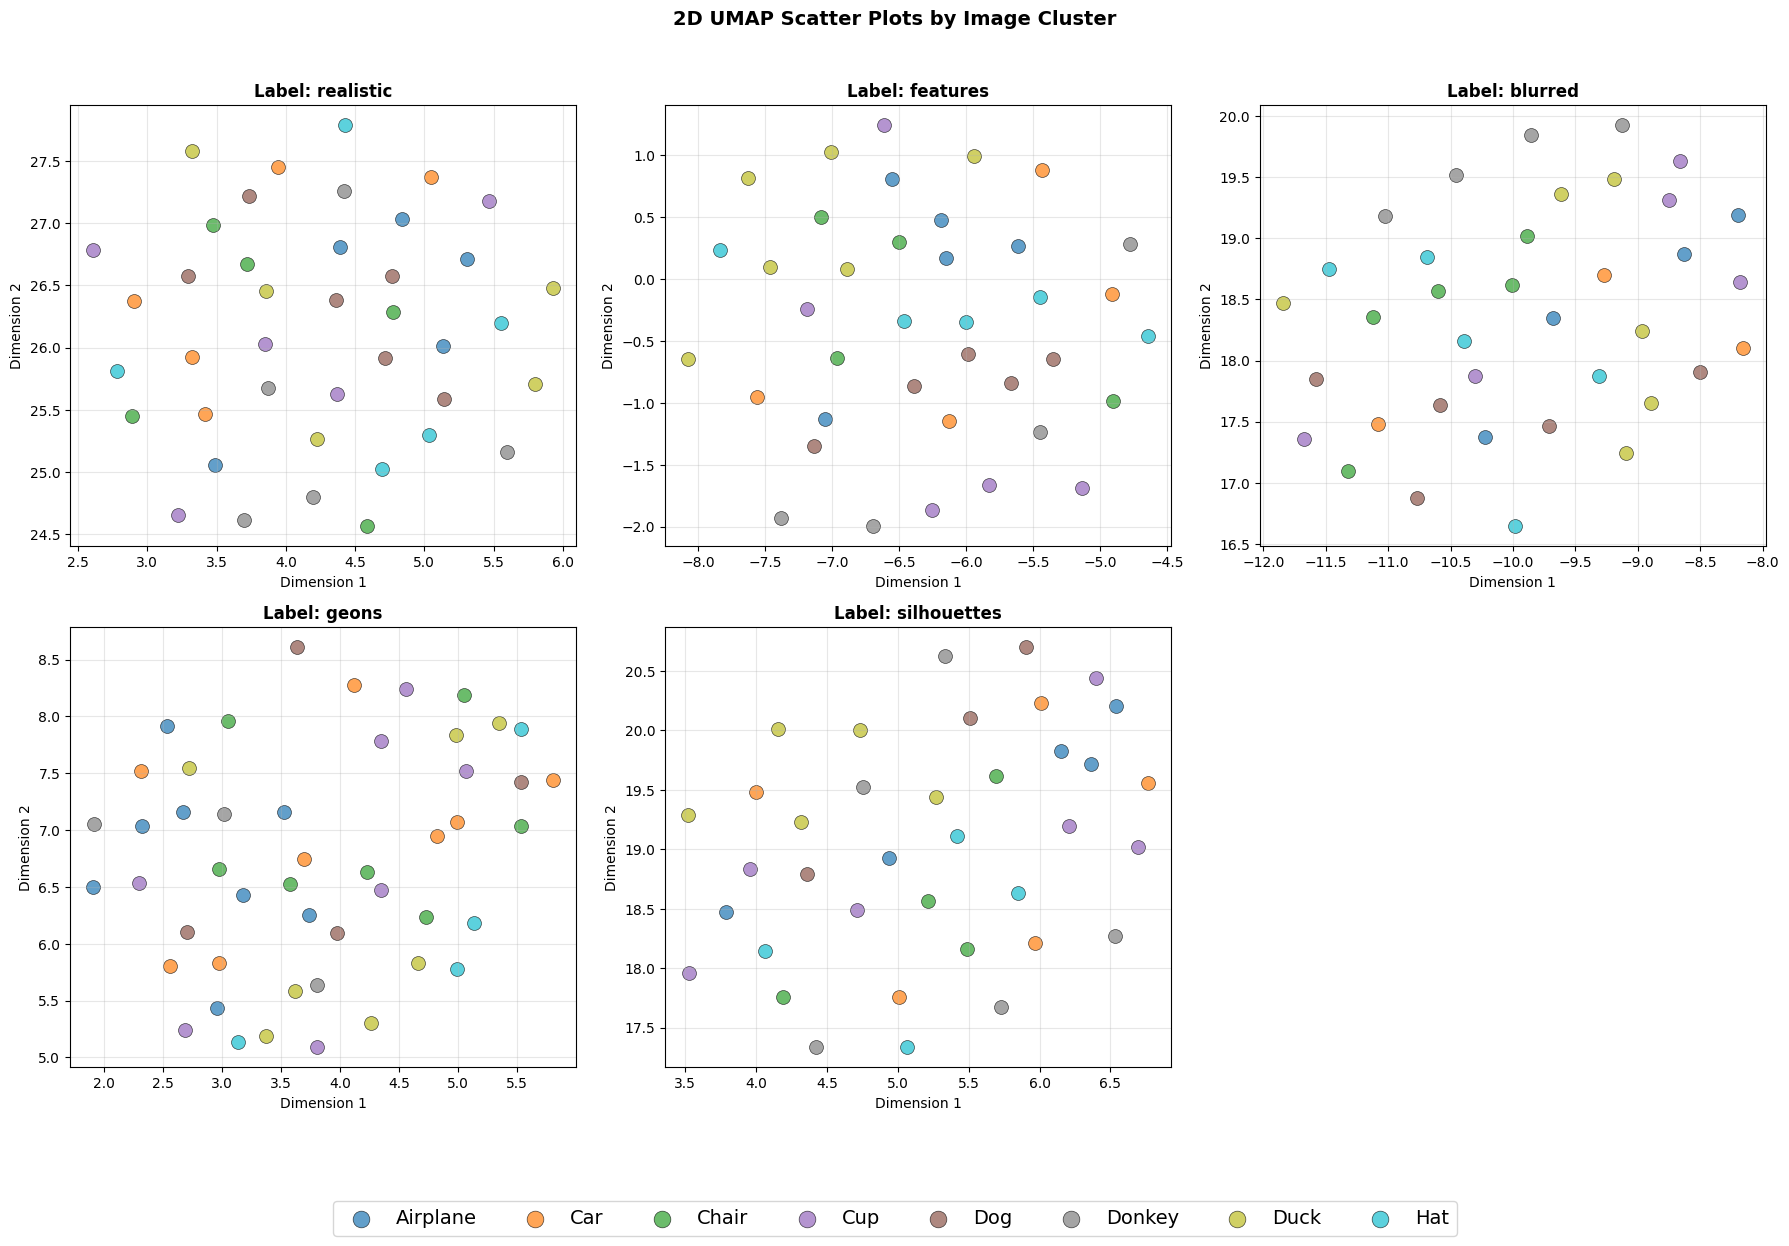

In [30]:
figure, axes = plot.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

legend_handles = []
legend_labels = []

for index, label in enumerate(LABELS):
    umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    principal_components = umap_model.fit_transform(data[label]['components'])
    
    clusters = []    
    paths = (PATH / label).iterdir()
    for path in paths: 
        cluster_name = next((cluster for cluster in CLUSTER_NAMES if cluster in path.stem), 'Unknown')
        clusters.append(cluster_name)
    
    axis = axes[index]  
    for cluster in CLUSTER_NAMES:         
        cluster_indices = [i for i, cluster_name in enumerate(clusters) if cluster_name == cluster]        
        if cluster_indices:  
            scatter = axis.scatter(
                principal_components[cluster_indices, 0], 
                principal_components[cluster_indices, 1], 
                color=cluster_colors[cluster], 
                label=cluster, 
                alpha=0.7, 
                s=100,
                edgecolors='black',
                linewidth=0.5
            )
            if index == 0: 
                legend_handles.append(scatter)
                legend_labels.append(cluster)
    
    axis.set_xlabel('Dimension 1', fontsize=10)
    axis.set_ylabel('Dimension 2', fontsize=10)
    axis.set_title(f'Label: {label}', fontsize=12, fontweight='bold')
    axis.grid(True, alpha=0.3)

if len(LABELS) < len(axes):
    figure.delaxes(axes[-1])

figure.legend(legend_handles, legend_labels, 
              loc='lower center', 
              ncol=len(CLUSTER_NAMES), 
              fontsize=14,
              markerscale=1.2,
              frameon=True,
              bbox_to_anchor=(0.5, -0.05)) 

plot.suptitle('2D UMAP Scatter Plots by Image Cluster', fontsize=14, fontweight='bold')
plot.tight_layout(rect=(0, 0.05, 1, 0.96)) 
plot.show()